In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

import harmonic_balance.utils as utils

ndarray = np.ndarray

In [ ]:
NH = 4
n = 2
m1, m2 = 1, 2
c1, c2, c3 = 1, 0.5, 2
k1, k2, k3 = 1, 0.5, 2

M = np.diag([m1, m2])
C = np.array([[c1 + c2, -c2], [-c2, c2 + c3]])
K = np.array([[k1 + k2, -k2], [-k2, k2 + k3]])

omega = 2
t0, tf = tlim = 0, 2 * np.pi / omega
tn = NH * 2
tls = np.linspace(*tlim, tn)

In [ ]:
A = utils.get_A(NH, omega, M, C, K)

b_ext = utils.get_b_ext(NH, n, (1,), (0,), (1,), (2,))

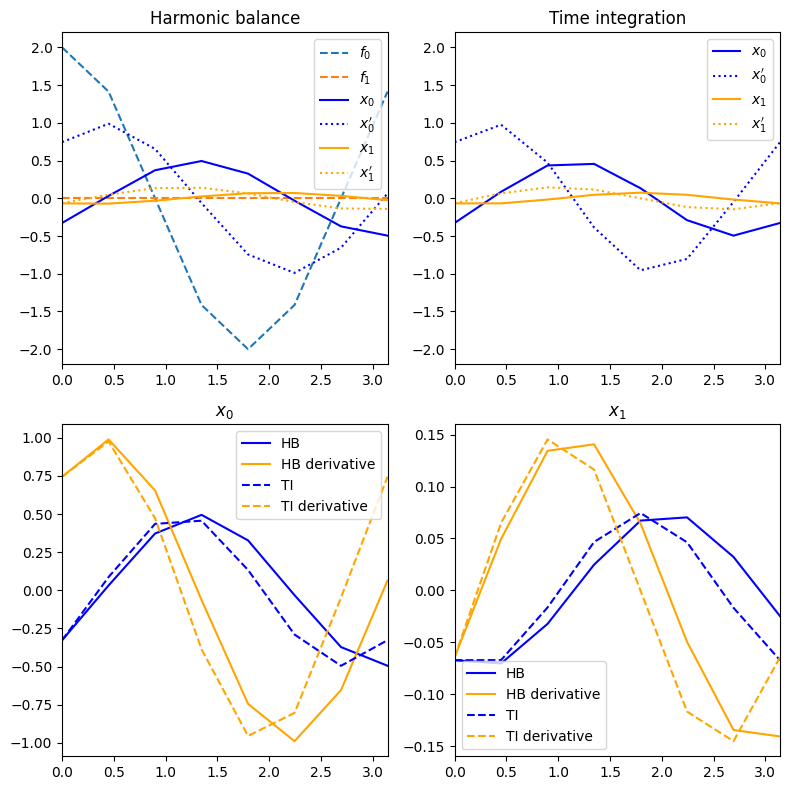

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
colors = ("blue", "orange")

ax = axs[0, 0]
ax.set_title("Harmonic balance")

bb_ext = utils.extract_dofs(b_ext.toarray(), NH, n)
ff = scipy.fft.irfft(bb_ext, axis=1, norm=utils.FFT_NORM)
names = [rf"f_{i}" for i in range(n)]
for f, color, name in zip(ff, colors, names):
    ax.plot(tls, f, label=f"${name}$", ls="--")

z = scipy.sparse.linalg.spsolve(A, b_ext)

zz = utils.extract_dofs(z, NH, n)
xx = scipy.fft.irfft(zz, axis=1, norm=utils.FFT_NORM)

derivative_factors = 1j * np.arange(NH + 1)
zzp = derivative_factors * zz * omega
xxp = scipy.fft.irfft(zzp, axis=1, norm=utils.FFT_NORM)

names = [rf"x_{i}" for i in range(n)]
for x, xp, color, name in zip(xx, xxp, colors, names):
    ax.plot(tls, x, color=color, label=rf"${name}$")
    ax.plot(tls, xp, color=color, label=rf"${name}'$", ls=":")
ax.legend()


ax = axs[0, 1]
ax.set_title("Time integration")

x0 = xx[:, 0]
xp0 = xxp[:, 0]
y0 = np.concat((x0, xp0))


def ode(t, y, *args):
    omega, M, C, K = args

    x = y[:n]
    xp = y[n:]

    f = np.array([2 * np.cos(omega * t), 0])

    xpp = np.linalg.inv(M) @ (-C @ xp - K @ x + f)
    return np.concat((xp, xpp))


args = (omega, M, C, K)
sol = scipy.integrate.solve_ivp(ode, tlim, y0, t_eval=tls, args=args)

xx_ti = sol.y[:n]
xxp_ti = sol.y[n:]

for x, xp, color, name in zip(xx_ti, xxp_ti, colors, names):
    ax.plot(tls, x, color=color, label=rf"${name}$")
    ax.plot(tls, xp, color=color, label=rf"${name}'$", ls=":")
ax.legend()
ax.set_ylim(axs[0, 0].get_ylim())


for i in range(n):
    ax = axs[1, i]
    ax.set_title(rf"${names[i]}$")
    ax.plot(tls, xx[i], color=colors[0], label="HB")
    ax.plot(tls, xxp[i], color=colors[1], label="HB derivative")
    ax.plot(tls, xx_ti[i], color=colors[0], label="TI", ls="--")
    ax.plot(tls, xxp_ti[i], color=colors[1], label="TI derivative", ls="--")
    ax.legend()

[ax.set_xlim(*tlim) for ax in axs.ravel()]

fig.tight_layout()
plt.show()

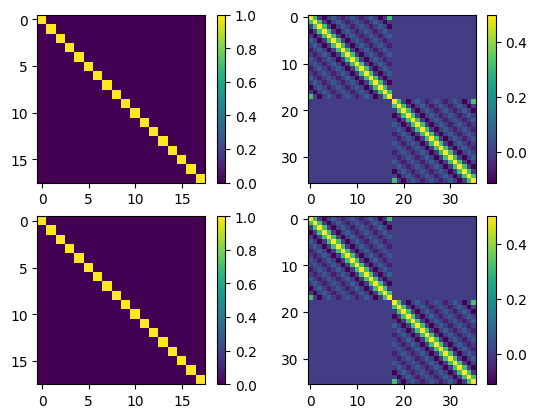

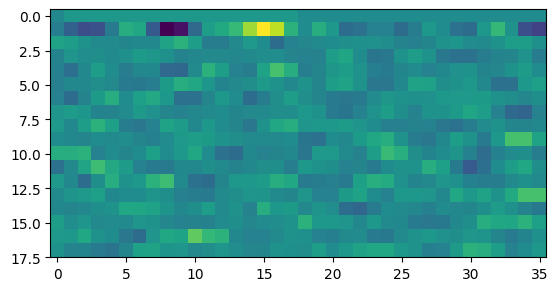

(array(1.22124533e-15), array(1.80411242e-16))

In [ ]:
import itertools

N = 18


def get_tls(omega, N):
    return 2 * np.pi * np.arange(N) / N / omega


def get_samples(omega, N, k, fn):
    tls = get_tls(omega, N)
    return fn(k * omega * tls)


def get_all_samples(omega, NH, N, constant_coefficient):
    cos_sin = [
        (get_samples(omega, N, k, np.cos), get_samples(omega, N, k, np.sin))
        for k in range(1, NH + 1)
    ]
    return [np.full(N, constant_coefficient)] + list(itertools.chain(*cos_sin))


def get_gamma_samples(omega, NH, N):
    return get_all_samples(omega, NH, N, 1 / 2)


def get_inv_gamma_samples(omega, NH, N):
    return [2 / N * samples for samples in get_all_samples(omega, NH, N, 1)]


def col(n, samples):
    # Taking the transpose is equivalent to transposing `samples` since the
    # identity is symmetric.
    return np.kron(np.eye(n), samples).T


def row(n, samples):
    return np.kron(np.eye(n), samples)


def get_gamma(n, NH, N):
    return np.concat(
        [col(n, samples) for samples in get_gamma_samples(omega, NH, N)], axis=1
    )


def get_inv_gamma(n, NH, N):
    return np.concat(
        [row(n, samples) for samples in get_inv_gamma_samples(omega, NH, N)],
        axis=0,
    )


gamma = get_gamma(n, NH, N)
inv_gamma = get_inv_gamma(n, NH, N)

fig, axs = plt.subplots(2, 2)
images = list()
images.append(axs[0, 0].imshow(np.linalg.pinv(gamma) @ gamma))
images.append(axs[0, 1].imshow(gamma @ np.linalg.pinv(gamma)))
images.append(axs[1, 0].imshow(inv_gamma @ gamma))
images.append(axs[1, 1].imshow(gamma @ inv_gamma))
[fig.colorbar(image) for image in images]
plt.show()

plt.imshow(inv_gamma - np.linalg.pinv(gamma))
plt.show()


def abs_max(a, axis=None):
    a_max = np.max(a, axis=axis)
    a_min = np.min(a, axis=axis)
    return np.where(-a_min > a_max, a_min, a_max)


(
    abs_max(gamma @ inv_gamma @ gamma - gamma),
    abs_max(inv_gamma @ gamma @ inv_gamma - inv_gamma),
)